In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
import scipy 
from scipy.optimize import minimize
from numpy import array
from sklearn.metrics import r2_score
from scipy import stats
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from scipy.stats import spearmanr, pearsonr
from skbio import DistanceMatrix
import warnings
warnings.filterwarnings("ignore")

# Read metadata

In [2]:
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)
df_meta_scfa = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_meta_scfa.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Iso-butyrate,Iso-valerate,Valerate,Total
SampleID,,,,,,,,,,,,
sample131,BC1,Beijing,0,Control,C,20.205741,3.297966,2.729283,0.253521,0.143931,0.111531,26.741973
sample132,BC2,Beijing,0,Control,B,15.789550,2.520570,2.439410,0.222235,0.095223,0.111324,21.178312
sample133,BC3,Beijing,0,Control,A,25.064928,5.569482,2.176445,0.586308,0.292805,0.411654,34.101622
sample134,BC4,Beijing,0,Control,D,16.980939,3.224844,2.513462,0.276614,0.126857,0.187956,23.310672
sample135,BC5,Beijing,0,Control,E,21.801265,4.224119,3.107713,0.356514,0.182745,0.218644,29.891000


# Fit harmonic oscillator model (for each SCFA and each mice)

In [3]:
def harmonic(params,xdata):
    k1,k2,D,H,Ai = params
    # original model is ypred = H+((D+k2*Ai-H*k2)*np.exp(-k1*xdata)-(D+k1*Ai-H*k1)*np.exp(-k2*xdata))/(k2-k1)
    # we used the following transformed because it is more numerically stable
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [4]:
def harmonic_2(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+(-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [5]:
def harmonic_1(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata))/(k2-k1)
    return ypred

In [6]:
def residual_harmonic(params,xdata,ydata):
    ypred = harmonic(params,xdata)
    return -r2_score(ydata, ypred)

In [ ]:
df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
all_mice = list(set(df_meta_scfa_inulin.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
                if initial_condition=='freeIC':
                    res = minimize(residual_harmonic, 
                                   [random(),random(),random(),random(),random()], 
                                   args=(xdata,ydata),
                                   bounds = ((0, 1), (0, 1), (0, None), (0, None), (0,None)),
                                   method='Powell', # Powell
                                   tol=1e-8,
                                   options={'maxiter':1000}
                                  )
                elif initial_condition=='fixedIC':
                    res = minimize(residual_harmonic, 
                       [random(),random(),random(),random(),ydata[0]], 
                       args=(xdata,ydata),
                       bounds = ((0, 1), (0, 1), (0, None), (0, None), (ydata[0],ydata[0])),
                       method='Powell', # Powell
                       tol=1e-8,
                       options={'maxiter':1000}
                      )
                else:
                    print('unknown initial condition: %s'%(initial_condition))
                    raise
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, harmonic(best_sol_over, xdata))])

# write to file
df_bfit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','k1','k2','D','H','Ai','R2'])
df_bfit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_bfit['k1'],df_bfit['k2'])]
df_bfit.to_csv('best_fit_parameters_inulin_%s_harmonic.csv'%(initial_condition))

Acetate BI4
[3.73946108e-09 9.99999888e-01 4.93205766e+00 1.12020451e-01
 1.25803680e+01]


In [11]:
df_bfit_harmonic = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_harmonic['R2'].mean(), df_bfit_harmonic['R2'].std())

0.6689575622777779 0.22162656815684045


# Compare R2 between inulin and resistant starch

In [15]:
df_bfit_inulin = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_inulin['R2'].mean(), df_bfit_inulin['R2'].std())

0.6689575622777779 0.22162656815684045


In [17]:
df_bfit_rs = pd.read_csv('../resistant_starch/best_fit_parameters_resistant_starch_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_rs['R2'].mean(), df_bfit_rs['R2'].std())

0.33627349136755547 0.27299645721655585


In [18]:
scipy.stats.mannwhitneyu(df_bfit_inulin['R2'],df_bfit_rs['R2'])

MannwhitneyuResult(statistic=1028.0, pvalue=4.182570411615639e-12)

# Plot harmonic fitting for inulin mice

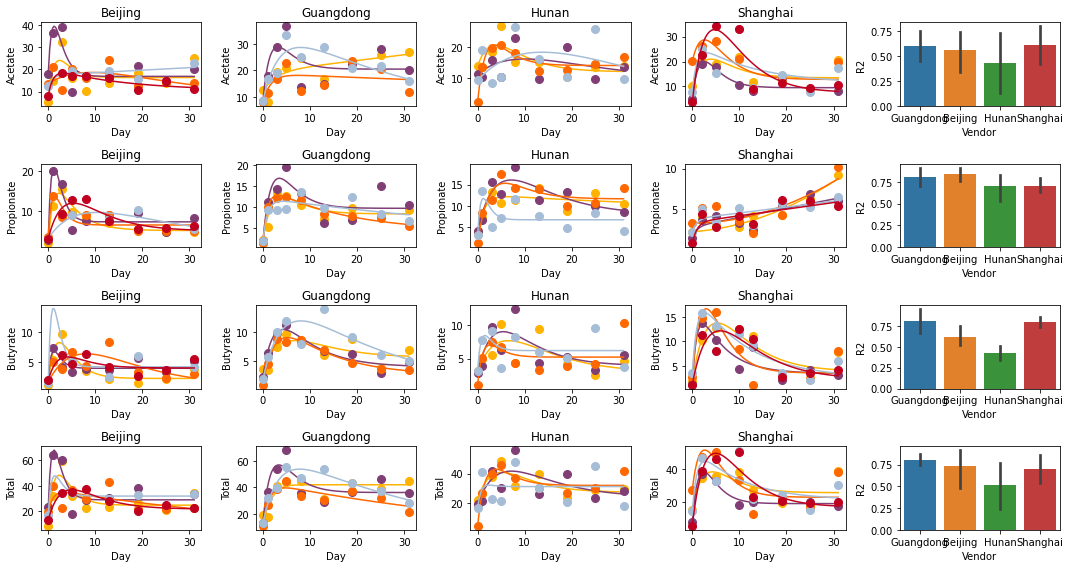

In [6]:
fig, ax = plt.subplots(figsize=(15, 8), nrows=4, ncols=5)
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)

df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, vendor_ in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.Vendor==vendor_]
        for k, mice_ in enumerate(set(curr_df.MiceID)):
            curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')
            
            # get X and Y data
            xdata = np.array(curr_df2.Day)
            ydata = np.array(curr_df2[scfa_])
            ax[i,j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

            xdata_dense = np.linspace(0,31,100)
            best_sol_over = df_bfit.loc[(df_bfit.MiceID==mice_)&(df_bfit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
            ypred = harmonic(best_sol_over, xdata_dense)
            ax[i,j].plot(xdata_dense, ypred, color=colors[k])
            ax[i,j].set_title(vendor_)
            ax[i,j].set_xlabel('Day')
            ax[i,j].set_ylabel(scfa_)
    
    # plot R2
    _ = sns.barplot(x='Vendor', y='R2', data=df_bfit.loc[df_bfit.SCFA==scfa_], ax=ax[i,4])
                
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("harmonic_fitting_scfa_inulin_fixedIC.svg", format="svg")

# Decompose harmonic function

Text(0.5, 0, 'Day')

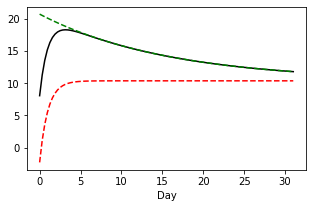

In [45]:
fig, ax = plt.subplots(figsize=(5, 3), nrows=1, ncols=1)
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)

df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'

mice_ = 'BI5'
scfa_ = 'Acetate'
xdata_dense = np.linspace(0,31,100)
best_sol_over = df_bfit.loc[(df_bfit.MiceID==mice_)&(df_bfit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
ypred_full = harmonic(best_sol_over, xdata_dense)
ypred_1 = harmonic_1(best_sol_over, xdata_dense)
ypred_2 = harmonic_2(best_sol_over, xdata_dense)
ax.plot(xdata_dense, ypred_full, 'k-')
ax.plot(xdata_dense, ypred_1, 'r--')
ax.plot(xdata_dense, ypred_2, 'g--')
ax.set_xlabel('Day')
    
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("harmonic_fitting_scfa_inulin_fixedIC.svg", format="svg")

# Plot D and zeta

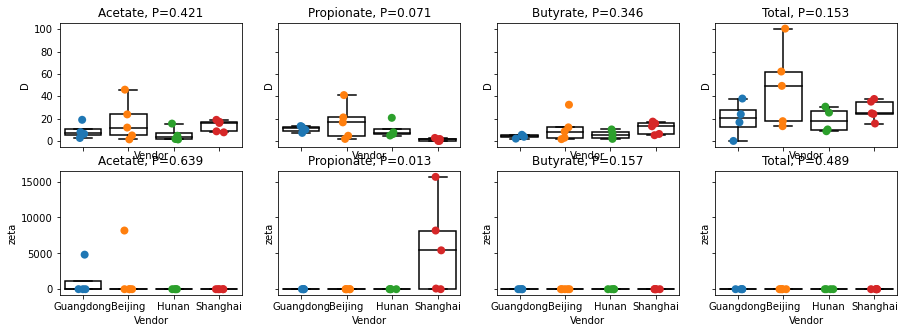

In [9]:
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
df_bfit['log10zeta'] = np.log10(df_bfit['zeta'])
df_bfit = df_bfit[['MiceID','SCFA','Vendor','D','zeta']]

# plot statistical comparison
fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=4, sharex=True, sharey='row')
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

for i,par in enumerate(['D','zeta']):
    for j,scfa in enumerate(['Acetate','Propionate','Butyrate','Total']):
        df_tmp = df_bfit[df_bfit.SCFA==scfa]
        _ = sns.boxplot(x='Vendor', y=par, hue='Vendor',data=df_tmp, color=None, dodge=False, ax=ax[i,j], showfliers=False, **PROPS)
        _ = sns.stripplot(x='Vendor', y=par, data=df_tmp, size=8, dodge=False, ax=ax[i,j])
        _ = ax[i,j].legend().remove()

        # group-wise test
        dm = pdist(np.asarray(df_tmp[par].values).reshape(-1,1), metric='minkowski')
        DM = DistanceMatrix(dm,list(df_tmp.MiceID))
        stats = permanova(DM, grouping=list(df_tmp.Vendor), permutations=999)
        _ = ax[i,j].set_title('%s, P=%2.3f'%(scfa, stats['p-value']))

# save figure
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("individualized_response_harmonic_model_D_log10zeta.svg", format="svg")

In [15]:
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
df_bfit = df_bfit[['SCFA','Vendor','zeta']]
df_bfit[df_bfit.SCFA=='Total'].sort_values('Vendor')

,SCFA,Vendor,zeta
71,Total,Beijing,1.000000
56,Total,Beijing,1.000000
67,Total,Beijing,1.000000
65,Total,Beijing,3.802969
64,Total,Beijing,1.002957
69,Total,Guangdong,3.376920
63,Total,Guangdong,1.000055
54,Total,Guangdong,1.797980
55,Total,Guangdong,1.000000
58,Total,Hunan,1.000000


# Plot 1/k1 and 1/k2

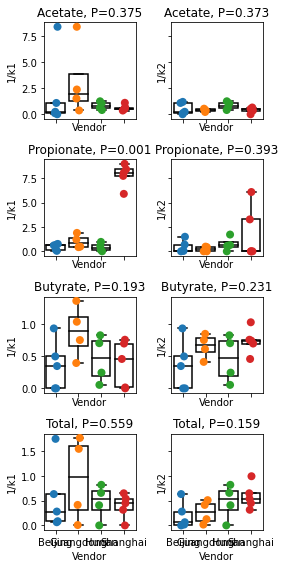

In [19]:
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
df_bfit = df_bfit[['MiceID','SCFA','Vendor','k1','k2']]
df_bfit['1/k1'] = np.log10(1/df_bfit['k1'])
df_bfit['1/k2'] = np.log10(1/df_bfit['k2'])

# plot statistical comparison
fig, ax = plt.subplots(figsize=(4, 8), nrows=4, ncols=2, sharex=True, sharey='row')
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

for i,scfa in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j,par in enumerate(['1/k1','1/k2']):
        df_tmp = df_bfit[df_bfit.SCFA==scfa]
        _ = sns.boxplot(x='Vendor', y=par, hue='Vendor',data=df_tmp, order=['Beijing','Guangdong','Hunan','Shanghai'], color=None, dodge=False, ax=ax[i,j], showfliers=False, **PROPS)
        _ = sns.stripplot(x='Vendor', y=par, data=df_tmp, order=['Beijing','Guangdong','Hunan','Shanghai'], size=8, dodge=False, ax=ax[i,j])
        _ = ax[i,j].legend().remove()

        # group-wise test
        dm = pdist(np.asarray(df_tmp[par].values).reshape(-1,1), metric='minkowski')
        DM = DistanceMatrix(dm,list(df_tmp.MiceID))
        stats = permanova(DM, grouping=list(df_tmp.Vendor), permutations=999)
        _ = ax[i,j].set_title('%s, P=%2.3f'%(scfa, stats['p-value']))

plt.tight_layout()
# save figure
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("individualized_response_harmonic_model_k1_k2.svg", format="svg")